In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Import data

In [ ]:
gdpnow = pd.read_csv('test_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

## Let's define X and y

In [4]:
#Target S&P
Target = 'SPX Index '
Drop = ['Final_GDP_Interp','Quarter being forecasted', 'Advance Estimate From BEA',
        'Publication Date of Advance Estimate','Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# Target 2y Interest Rates
# Target = 'USOSFR2 Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

# #Target GDP
# Target = 'Final_GDP_Interp'
# Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#       'Days until advance estimate', 'Forecast Error', 'Data releases']

# Load Train and Test

In [ ]:
gdpnow_filled.shape, gdpnow_dropped.shape

# Defining X and y

We now need the X and Y from the whole train and predict set that includes btm_gdp

In [6]:
# Splitting into test and train sets

train = pd.read_csv('train_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_train = train.drop(columns=Drop)
y_train = train[Target]

test = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_test = test.drop(columns=Drop)
y_test = test[Target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3551, 65) (3551,)
(63, 65) (63,)


In [23]:
# Concatenate features (adding X_test to the bottom of X_train)
X = pd.concat([X_train, X_test])
# Concatenate labels (adding y_test to the bottom of y_train)
y = pd.concat([y_train, y_test])

print(X.shape, y.shape)


(3614, 65) (3614,)


### Optuna with Preproc

In [7]:


# # Assuming X_dropped and y_dropped are your dataset

# def objective(trial):
#     # Suggest values for the preprocessing parameters
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 3)
#     percentile = trial.suggest_int('percentile', 40, 80)

#     # Create the preprocessing pipeline with suggested parameters
#     preproc = Pipeline([
#         ('imputer', KNNImputer(n_neighbors=n_neighbors)),
#         ('scaler', RobustScaler()),
#         ('feature_selection', SelectPercentile(mutual_info_regression, percentile=percentile))
#     ])

#     X_preproc_train = preproc.fit_transform(X_train, y_train)

#     # Suggest values for the model's hyperparameters
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.25),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.0, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
#     }

#     # Initialize and train the XGBoost regressor
#     model = xgb.XGBRegressor(**params)
#     model.fit(X_preproc_train, y_train)

#     # Make predictions on the processed test set
#     X_preproc_test = preproc.transform(X_test)
#     preds = model.predict(X_preproc_test)

#     # Evaluate the model using negative mean absolute error
#     neg_mae = -mean_absolute_error(y_test, preds)

#     return neg_mae  # Optimize for neg_MAE

# # Create and execute the Optuna study
# study = optuna.create_study(direction='maximize')  # We are minimizing the negative MAE
# study.optimize(objective, n_trials=500)  # Adjust n_trials based on computational budget

# # Print best trial results
# print("Best trial:")
# trial = study.best_trial
# print(f" Value (neg_MAE): {trial.value:.4f}")
# for key, value in trial.params.items():
#     print(f" {key}: {value}")


[I 2024-03-22 12:59:03,394] A new study created in memory with name: no-name-303c2b49-c182-4e67-8d5e-e912aa293d17
[I 2024-03-22 12:59:07,998] Trial 0 finished with value: -439.67932880704376 and parameters: {'n_neighbors': 3, 'percentile': 43, 'max_depth': 28, 'learning_rate': 0.20073122369550675, 'n_estimators': 262, 'min_child_weight': 8, 'gamma': 0.6568561692010358, 'subsample': 0.7252481795875099, 'colsample_bytree': 0.8695473144912179, 'reg_alpha': 0.27294711257579685, 'reg_lambda': 4.979040745623063}. Best is trial 0 with value: -439.67932880704376.
[I 2024-03-22 12:59:13,340] Trial 1 finished with value: -364.0665435887898 and parameters: {'n_neighbors': 1, 'percentile': 61, 'max_depth': 41, 'learning_rate': 0.2039592942970939, 'n_estimators': 866, 'min_child_weight': 6, 'gamma': 0.743604662842918, 'subsample': 0.6973613876270457, 'colsample_bytree': 0.9872693009569518, 'reg_alpha': 0.17203816607411226, 'reg_lambda': 7.969342056359011}. Best is trial 1 with value: -364.066543588

Best trial:
 Value (neg_MAE): -203.2382
 n_neighbors: 2
 percentile: 49
 max_depth: 5
 learning_rate: 0.2468099773819122
 n_estimators: 852
 min_child_weight: 7
 gamma: 0.18297032462072674
 subsample: 0.564931447174437
 colsample_bytree: 0.5568967667312782
 reg_alpha: 0.2224244648875362
 reg_lambda: 6.111158890486282


# Pipeline

In [ ]:
# preproc = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', RobustScaler())
# ])

# preproc_selector = Pipeline([
#     ('preprocessing', preproc),  # Include the preprocessing steps with PCA
#     ('feature_selection', SelectPercentile(
#         mutual_info_regression))
# ])

# Modeling

In [ ]:
""" #Modeling with initial dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [10, 15, 20],
    'model__reg_alpha': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)
    'model__reg_lambda': [0, 0.1, 1.0],
    'preprocessor__feature_selection__percentile' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)

}

pipe = Pipeline([
     ('preprocessor', preproc_selector),
     ('model', model)
 ])

random_search = RandomizedSearchCV(
     pipe,
     param_distributions=param_distributions,
     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
     cv=5,
     verbose=2,
     #random_state=42,
     n_jobs=-1  # Use all available cores
 )

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_) """

In [ ]:
random_search.score(X_test, y_test)

In [ ]:
y_pred = random_search.predict(X_test)

# Best Parameters

In [8]:
trial.params

{'n_neighbors': 2,
 'percentile': 49,
 'max_depth': 5,
 'learning_rate': 0.2468099773819122,
 'n_estimators': 852,
 'min_child_weight': 7,
 'gamma': 0.18297032462072674,
 'subsample': 0.564931447174437,
 'colsample_bytree': 0.5568967667312782,
 'reg_alpha': 0.2224244648875362,
 'reg_lambda': 6.111158890486282}

# Fitting best model 

In [9]:

# Extract best parameters for preprocessing and model
# best_params = study.best_trial.params
# best_params = {
#     'n_neighbors': 3,
#     'percentile': 49,
#     'max_depth': 9,
#     'learning_rate': 0.2498773755675101,
#     'n_estimators': 1099,
#     'min_child_weight': 5,
#     'gamma': 4.948772788547994e-05,
#     'subsample': 0.8451156656189625,
#     'colsample_bytree': 0.6148165960748299,
#     'reg_alpha': 0.3365824497976371,
#     'reg_lambda': 3.450245765937823
# }

# S&P Best Params
best_params =  {'n_neighbors': 2,
 'percentile': 49,
 'max_depth': 5,
 'learning_rate': 0.2468099773819122,
 'n_estimators': 852,
 'min_child_weight': 7,
 'gamma': 0.18297032462072674,
 'subsample': 0.564931447174437,
 'colsample_bytree': 0.5568967667312782,
 'reg_alpha': 0.2224244648875362,
 'reg_lambda': 6.111158890486282}

# Create the optimal preprocessing pipeline
preproc_optimal = Pipeline([
    ('imputer', KNNImputer(n_neighbors=best_params['n_neighbors'])),
    ('scaler', RobustScaler()),
    ('feature_selection', SelectPercentile(mutual_info_regression, percentile=best_params['percentile']))
])

# Create the model with optimal parameters
model_optimal = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda']
)

# # Combine into a single pipeline
# pipe_optimal = Pipeline([
#     ('preprocessing', preproc_optimal),
#     ('model', model_optimal)
# ])


In [24]:
# Combine into a single pipeline
pipe_best = Pipeline([
    ('preprocessing', preproc_optimal),
    ('model', model_optimal)
])

# Fit the optimal pipeline to the trainin
pipe_best.fit(X, y)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X, y, cv=5, scoring='neg_mean_absolute_error')


# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

155.17230624359786
-306.28728518923947


# Predictions on X_test

In [25]:
y_pred = pipe_best.predict(X_test)

In [26]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [27]:
y_pred.index = y_test.index
df_plot = pd.DataFrame()
df_plot = pd.concat([y_test, y_pred], axis=1)


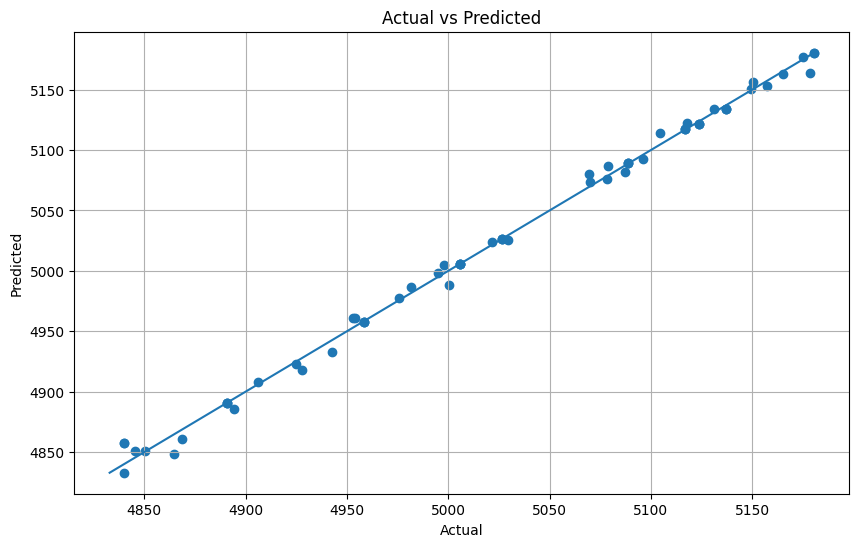

In [28]:
# Compute dynamic min and max for the line
min_val = min(df_plot[Target].min(), df_plot[0].min())
max_val = max(df_plot[Target].max(), df_plot[0].max())

# Adjust a and b dynamically
a = [min_val, max_val]
b = [min_val, max_val]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot[Target], df_plot[0] )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Loss curves

[0]	validation_0-mae:570.57281	validation_1-mae:1633.35198
[1]	validation_0-mae:413.78764	validation_1-mae:1389.02829
[2]	validation_0-mae:300.09295	validation_1-mae:1212.65733
[3]	validation_0-mae:217.66536	validation_1-mae:1078.79993
[4]	validation_0-mae:157.93492	validation_1-mae:985.39473
[5]	validation_0-mae:114.60991	validation_1-mae:921.61571
[6]	validation_0-mae:83.20965	validation_1-mae:867.97307
[7]	validation_0-mae:60.49396	validation_1-mae:803.31114
[8]	validation_0-mae:44.00133	validation_1-mae:773.87343
[9]	validation_0-mae:32.03290	validation_1-mae:739.60082
[10]	validation_0-mae:23.36248	validation_1-mae:719.34859
[11]	validation_0-mae:17.16165	validation_1-mae:704.15124
[12]	validation_0-mae:12.71024	validation_1-mae:693.37788
[13]	validation_0-mae:9.52897	validation_1-mae:685.60103
[14]	validation_0-mae:7.31742	validation_1-mae:682.74191
[15]	validation_0-mae:5.78743	validation_1-mae:674.84136
[16]	validation_0-mae:4.79989	validation_1-mae:672.65337
[17]	validation_0-

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:3.07191	validation_1-mae:661.81176
[21]	validation_0-mae:2.91606	validation_1-mae:659.60724
[22]	validation_0-mae:2.79647	validation_1-mae:659.34650
[23]	validation_0-mae:2.66848	validation_1-mae:657.38599
[24]	validation_0-mae:2.57810	validation_1-mae:657.49372
[25]	validation_0-mae:2.48063	validation_1-mae:657.27693
[26]	validation_0-mae:2.41308	validation_1-mae:657.22322
[27]	validation_0-mae:2.35640	validation_1-mae:657.41656
[28]	validation_0-mae:2.31408	validation_1-mae:657.37505
[29]	validation_0-mae:2.25416	validation_1-mae:657.40962
[30]	validation_0-mae:2.19795	validation_1-mae:655.81266
[31]	validation_0-mae:2.15381	validation_1-mae:655.75553
[32]	validation_0-mae:2.10548	validation_1-mae:655.75601
[33]	validation_0-mae:2.06590	validation_1-mae:654.48247
[34]	validation_0-mae:2.02924	validation_1-mae:654.46001
[35]	validation_0-mae:2.00350	validation_1-mae:654.36801
[36]	validation_0-mae:1.99035	validation_1-mae:654.37322
[37]	validation_0-mae:1.95510	v

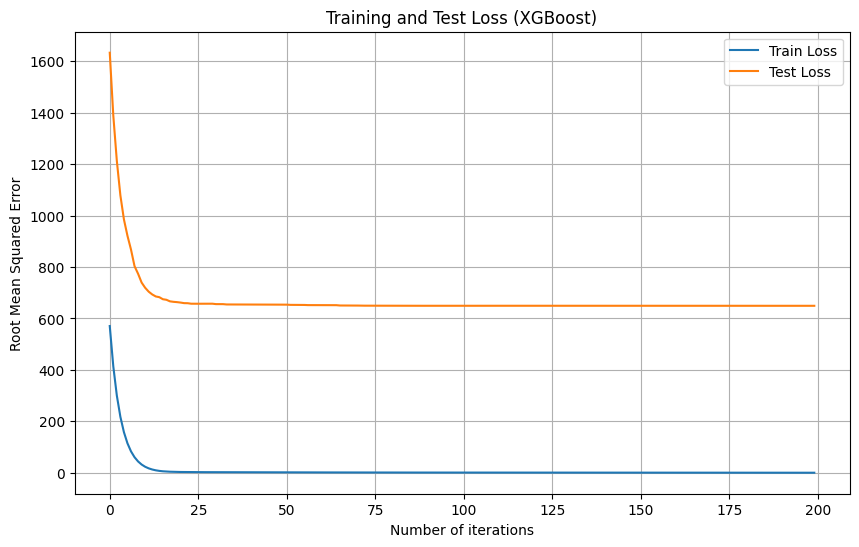

In [29]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_optimal.fit_transform(X_train, y_train)
X_test_preproc = preproc_optimal.transform(X_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_train), (X_test_preproc, y_test)]
xgb_regressor.fit(X_train_preproc, y_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Predictions on Unseen data (> 19/01/2024)

In [30]:
predict_data = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True)

predict_data.index = pd.to_datetime(predict_data.index)

unseen_X = predict_data.drop(columns=Drop)
unseen_y = predict_data[Target]

assert(unseen_X.shape[0]==unseen_y.shape[0])

In [31]:
predictions = pipe_best.predict(unseen_X)

predictions = pd.Series(predictions)
predictions.index = unseen_y.index

df_plot = pd.DataFrame()
df_plot = pd.concat([unseen_y, predictions], axis=1)
df_plot

,SPX Index,0
Dates,,
2024-01-19,4839.81,4880.433105
2024-01-20,4839.81,4897.287598
2024-01-21,4839.81,4897.287598
2024-01-22,4850.43,4904.005859
2024-01-23,4864.60,4896.910645
...,...,...
2024-03-17,5117.09,4973.674805
2024-03-18,5149.42,5005.640625
2024-03-19,5178.51,5008.434570


In [32]:
from sklearn.metrics import mean_absolute_error

# Assuming you have y_test and y_pred
mae = mean_absolute_error(unseen_y, predictions)
mae

110.24453776041655

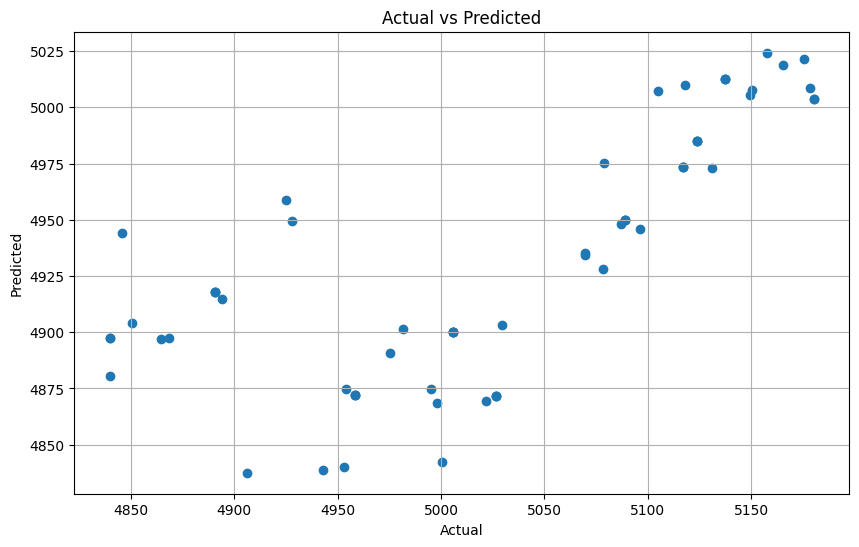

In [34]:

plt.figure(figsize=(10, 6))

scatter = plt.scatter(df_plot[Target], df_plot[0] )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

## Shapley Feature Test

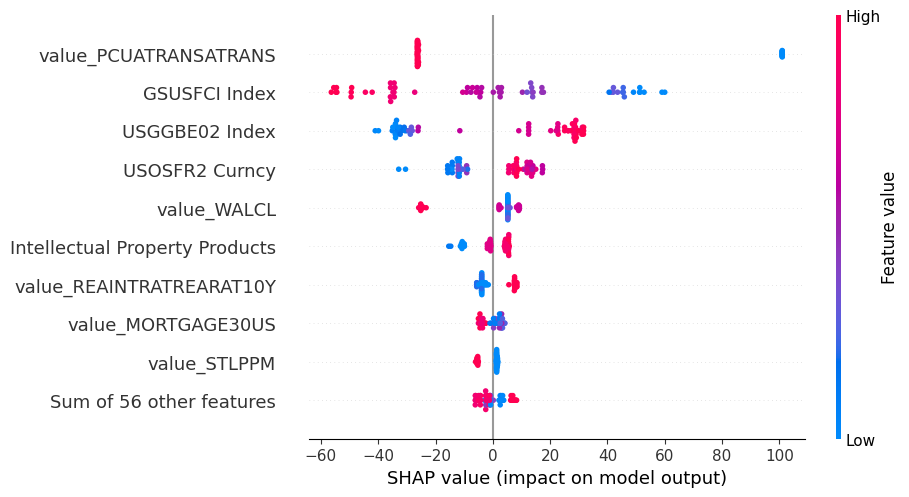

In [35]:
# Feature Selection
import shap
# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)
# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.beeswarm(shap_values)
#change

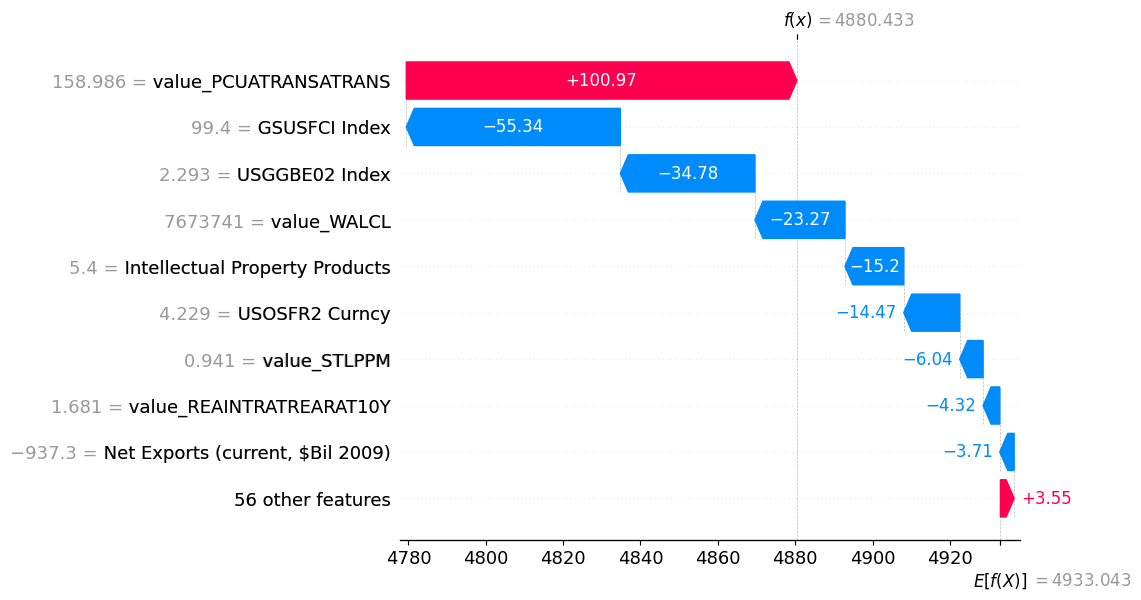

In [37]:
# Feature Selection
import shap

# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)

# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.waterfall(shap_values[0])
#change